# **Lab 3** - Multi-Metric Bug Context Analysis and Agreement Detection in Bug-Fix Commits

**CS202 - Software Tools and Techniques for CSE**

Bhavya Parmar

23110059

In [1]:
!pip install radon
!pip install sacrebleu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 5.4 MB/s eta 0:00:00


In [2]:
import pandas as pd
from radon.metrics import mi_visit
from radon.complexity import cc_visit
from radon.raw import analyze

In [3]:
dataset = pd.read_csv('/kaggle/input/diff-analysis-stt/diff_analysis.csv')
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1095 entries, 0 to 1094
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   #                      1095 non-null   object
 1   Message                1095 non-null   object
 2   Filename               1095 non-null   object
 3   Source Code (before)   1004 non-null   object
 4   Source Code (current)  845 non-null    object
 5   Diff                   1092 non-null   object
 6   Fix Type (LLM)         1095 non-null   object
 7   Rectified Message      1095 non-null   object
dtypes: object(8)
memory usage: 68.6+ KB


In [4]:
dataset.head()

,#,Message,Filename,Source Code (before),Source Code (current),Diff,Fix Type (LLM),Rectified Message
0,da717455e94c5e8e95f71316f8b02c7a0e3020a9,Implemented Early stopping and few other bug f...,protocol.py,import numpy as np\nfrom tqdm import tqdm\nfro...,import numpy as np\nfrom tqdm import tqdm\nfro...,"@@ -444,6 +444,9 @@ def evaluate_performance(X...",add end_evaluation to performance_test.py,dev
1,da717455e94c5e8e95f71316f8b02c7a0e3020a9,Implemented Early stopping and few other bug f...,models.py,import numpy as np\nimport tensorflow as tf\nf...,import numpy as np\nimport tensorflow as tf\nf...,"@@ -4,7 +4,7 @@ from sklearn.utils import chec...",SKIPPED,dev
2,a36faa9feafed55dca3d1d0d7341c39c01f1549f,Resolved indentation issue.\n\nIntegration tes...,models.py,import numpy as np\nimport tensorflow as tf\nf...,import numpy as np\nimport tensorflow as tf\nf...,"@@ -303,17 +303,12 @@ class EmbeddingModel(abc...",add support for negative matrix in tf embeddings,dev
3,8c5f964f01b9b7bc141db71789553c4cbbc29498,Updated issue templates,bug_report.md,NaN,---\nname: Bug report\nabout: Describe the pro...,"@@ -0,0 +1,16 @@\n+---\n+name: Bug report\n+ab...",add missing description to reportnofilter,llm
4,8c5f964f01b9b7bc141db71789553c4cbbc29498,Updated issue templates,feature_request.md,NaN,---\nname: Feature request\nabout: Suggest a n...,"@@ -0,0 +1,12 @@\n+---\n+name: Feature request...",add missing missing tag,llm


In [5]:
'''
Computing Baseline Descriptive Statistics
'''
# Total number of commits and files
n_commits = len(dataset['#'].unique())
n_files = len(dataset)

# Average number of modified files per commit
avg_files_per_commit = n_files/n_commits

# Distribution of fix types from LLM Inference (fix type)
fix_type_dist = dataset['Fix Type (LLM)'].value_counts()

# Most frequently modified filenames and extensions
dataset['Extension'] = dataset['Filename'].apply(
    lambda x: x.split('.')[-1] if '.' in x else 'NO_EXT'
)
ext_dist = dataset['Extension'].value_counts()
filename_dist = dataset['Filename'].value_counts()

print(f"Total commits = {n_commits}\n")
print(f"Total modified files = {n_files}\n")
print(f"Average number of modified files per commit = {round(avg_files_per_commit,2)}\n")
print(f"LLM fix-type distribution: \n{fix_type_dist}\n")
print(f"Frequently modified extensions: \n{ext_dist.head(10)}\ncount = {len(ext_dist)}\n")
print(f"Frequently modified filenames:  \n{filename_dist.head(20)}\ncount = {len(filename_dist)}")

Total commits = 295

Total modified files = 1095

Average number of modified files per commit = 3.71

LLM fix-type distribution: 
Fix Type (LLM)
SKIPPED                                                   174
add missing line                                           46
add missing missing tag                                    43
add missing docstring                                      35
add missing import                                         33
                                                         ... 
add tests for new version of the partitioning reporter      1
add tests for memory size and human readable size           1
add missing skip to test_partitioning_reporter              1
add more stats to the memory stats plot                     1
add tests for dummy backend                                 1
Name: count, Length: 452, dtype: int64

Frequently modified extensions: 
Extension
py       661
rst      303
md        36
ipynb     19
js        13
json      10
yml        9

In [6]:
dataset.drop('Extension', axis = 1, inplace = True)

In [7]:
'''
Computing Structural Metrics with radon
'''

for col in ["MI_Change", "CC_Change", "LOC_Change"]:
    dataset[col] = None
    
for i, row in dataset.iterrows():
    code_before = row['Source Code (before)']
    code_curr = row['Source Code (current)']

    try:
        # Maintainability Index
        mi_before = mi_visit(code_before, False) if code_before else None
        mi_after  = mi_visit(code_curr, False) if code_curr else None
        mi_change = (mi_after - mi_before) if (mi_before is not None and mi_after is not None) else None
        
        # Cyclomatic Complexity (sum across functions/methods)
        cc_before_blocks = cc_visit(code_before) if code_before else []
        cc_after_blocks  = cc_visit(code_curr) if code_curr else []
        cc_before = sum(b.complexity for b in cc_before_blocks) if cc_before_blocks else None
        cc_after  = sum(b.complexity for b in cc_after_blocks) if cc_after_blocks else None
        cc_change = (cc_after - cc_before) if (cc_before is not None and cc_after is not None) else None
        
        # Lines of Code
        raw_before = analyze(code_before) if code_before else None
        raw_after  = analyze(code_curr) if code_curr else None
        loc_before = raw_before.loc if raw_before else None
        loc_after  = raw_after.loc if raw_after else None
        loc_change = (loc_after - loc_before) if (loc_before is not None and loc_after is not None) else None
    
    except Exception as e:
        mi_before = mi_after = mi_change = None
        cc_before = cc_after = cc_change = None
        loc_before = loc_after = loc_change = None

    dataset.at[i, "MI_Change"] = mi_change
    dataset.at[i, "CC_Change"] = cc_change
    dataset.at[i, "LOC_Change"] = loc_change

dataset.head()

,#,Message,Filename,Source Code (before),Source Code (current),Diff,Fix Type (LLM),Rectified Message,MI_Change,CC_Change,LOC_Change
0,da717455e94c5e8e95f71316f8b02c7a0e3020a9,Implemented Early stopping and few other bug f...,protocol.py,import numpy as np\nfrom tqdm import tqdm\nfro...,import numpy as np\nfrom tqdm import tqdm\nfro...,"@@ -444,6 +444,9 @@ def evaluate_performance(X...",add end_evaluation to performance_test.py,dev,-0.104726,0,3
1,da717455e94c5e8e95f71316f8b02c7a0e3020a9,Implemented Early stopping and few other bug f...,models.py,import numpy as np\nimport tensorflow as tf\nf...,import numpy as np\nimport tensorflow as tf\nf...,"@@ -4,7 +4,7 @@ from sklearn.utils import chec...",SKIPPED,dev,-7.924797,19,73
2,a36faa9feafed55dca3d1d0d7341c39c01f1549f,Resolved indentation issue.\n\nIntegration tes...,models.py,import numpy as np\nimport tensorflow as tf\nf...,import numpy as np\nimport tensorflow as tf\nf...,"@@ -303,17 +303,12 @@ class EmbeddingModel(abc...",add support for negative matrix in tf embeddings,dev,None,None,None
3,8c5f964f01b9b7bc141db71789553c4cbbc29498,Updated issue templates,bug_report.md,NaN,---\nname: Bug report\nabout: Describe the pro...,"@@ -0,0 +1,16 @@\n+---\n+name: Bug report\n+ab...",add missing description to reportnofilter,llm,None,None,None
4,8c5f964f01b9b7bc141db71789553c4cbbc29498,Updated issue templates,feature_request.md,NaN,---\nname: Feature request\nabout: Suggest a n...,"@@ -0,0 +1,12 @@\n+---\n+name: Feature request...",add missing missing tag,llm,None,None,None


In [3]:
dataset[['MI_Change', 'CC_Change', 'LOC_Change']].describe()

,MI_Change,CC_Change,LOC_Change
count,634.000000,562.000000,634.000000
mean,0.002146,0.548043,4.957413
std,3.074840,3.310224,149.094952
min,-22.338232,-46.000000,-3529.000000
25%,-0.147224,0.000000,0.000000
50%,0.000000,0.000000,1.000000
75%,0.000000,0.000000,5.000000
max,43.451548,22.000000,505.000000


In [8]:
'''
Defining Functions for Semantic & Token Similarity
'''

from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn.functional as F
import sacrebleu

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Load CodeBERT
tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base")
model = AutoModel.from_pretrained("microsoft/codebert-base").to(device)

def semantic_similarity(before, after):
    '''
    Computes cosine similarity between the two inputs
    '''
    if not before or not after:
        return None
        
    try:
        inputs1 = tokenizer(before, return_tensors="pt", truncation=True, max_length=512).to(device)
        inputs2 = tokenizer(after, return_tensors="pt", truncation=True, max_length=512).to(device)

        with torch.no_grad():
            emb1 = model(**inputs1).last_hidden_state.mean(dim=1)
            emb2 = model(**inputs2).last_hidden_state.mean(dim=1)

        sim = F.cosine_similarity(emb1, emb2).item()
        return sim
        
    except Exception:
        return None


def token_similarity(before, after):
    '''
    Computes the BLEU score between the two inputs using SacreBLEU
    '''
    if not before or not after:
        return None

    try:
        # Tokenize by whitespace
        ref = [" ".join(before.split())]   # reference must be list of strings
        cand = " ".join(after.split())     # candidate must be a string

        bleu = sacrebleu.sentence_bleu(cand, ref)
        return bleu.score / 100.0  # Normalize to [0,1]
        
    except Exception as e:
        return None

Using device: cuda


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/498 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

2025-09-03 18:18:29.531846: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756923509.712922      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756923509.766384      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [9]:
'''
Computing Semantic & Token Similarity
'''

dataset["Semantic_Similarity"] = None
dataset["Token_Similarity"] = None

for i, row in dataset.iterrows():
    before = row["Source Code (before)"]
    after = row["Source Code (current)"]

    sem_sim = semantic_similarity(before, after)
    tok_sim = token_similarity(before, after)

    dataset.at[i, "Semantic_Similarity"] = sem_sim
    dataset.at[i, "Token_Similarity"] = tok_sim

dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1095 entries, 0 to 1094
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   #                      1095 non-null   object
 1   Message                1095 non-null   object
 2   Filename               1095 non-null   object
 3   Source Code (before)   1004 non-null   object
 4   Source Code (current)  845 non-null    object
 5   Diff                   1092 non-null   object
 6   Fix Type (LLM)         1095 non-null   object
 7   Rectified Message      1095 non-null   object
 8   MI_Change              634 non-null    object
 9   CC_Change              562 non-null    object
 10  LOC_Change             634 non-null    object
 11  Semantic_Similarity    758 non-null    object
 12  Token_Similarity       758 non-null    object
dtypes: object(13)
memory usage: 111.3+ KB


In [10]:
dataset.head()

,#,Message,Filename,Source Code (before),Source Code (current),Diff,Fix Type (LLM),Rectified Message,MI_Change,CC_Change,LOC_Change,Semantic_Similarity,Token_Similarity
0,da717455e94c5e8e95f71316f8b02c7a0e3020a9,Implemented Early stopping and few other bug f...,protocol.py,import numpy as np\nfrom tqdm import tqdm\nfro...,import numpy as np\nfrom tqdm import tqdm\nfro...,"@@ -444,6 +444,9 @@ def evaluate_performance(X...",add end_evaluation to performance_test.py,dev,-0.104726,0,3,1.0,0.998374
1,da717455e94c5e8e95f71316f8b02c7a0e3020a9,Implemented Early stopping and few other bug f...,models.py,import numpy as np\nimport tensorflow as tf\nf...,import numpy as np\nimport tensorflow as tf\nf...,"@@ -4,7 +4,7 @@ from sklearn.utils import chec...",SKIPPED,dev,-7.924797,19,73,0.999617,0.883438
2,a36faa9feafed55dca3d1d0d7341c39c01f1549f,Resolved indentation issue.\n\nIntegration tes...,models.py,import numpy as np\nimport tensorflow as tf\nf...,import numpy as np\nimport tensorflow as tf\nf...,"@@ -303,17 +303,12 @@ class EmbeddingModel(abc...",add support for negative matrix in tf embeddings,dev,None,None,None,1.0,0.991727
3,8c5f964f01b9b7bc141db71789553c4cbbc29498,Updated issue templates,bug_report.md,NaN,---\nname: Bug report\nabout: Describe the pro...,"@@ -0,0 +1,16 @@\n+---\n+name: Bug report\n+ab...",add missing description to reportnofilter,llm,None,None,None,None,None
4,8c5f964f01b9b7bc141db71789553c4cbbc29498,Updated issue templates,feature_request.md,NaN,---\nname: Feature request\nabout: Suggest a n...,"@@ -0,0 +1,12 @@\n+---\n+name: Feature request...",add missing missing tag,llm,None,None,None,None,None


In [ ]:
dataset[['Semantic_Similarity', 'Token_Similarity']].describe()

,Semantic_Similarity,Token_Similarity
count,758.000000,758.000000
mean,0.999203,0.938233
std,0.003253,0.135047
min,0.967251,0.115192
25%,0.999757,0.943114
50%,1.000000,0.986843
75%,1.000000,0.997379
max,1.000000,1.000000


In [11]:
'''
Defining Function to Classify Changes
'''

def classify_agree(semantic_sim, token_sim, semantic_th=0.80, token_th=0.75):
    """
    Classify changes as Major/Minor based on thresholds.
    Returns semantic_class, token_class, agreement
    """
    # Semantic classification
    if semantic_sim is None:
        semantic_class = None
    else:
        semantic_class = "Minor" if semantic_sim >= semantic_th else "Major"

    # Token classification
    if token_sim is None:
        token_class = None
    else:
        token_class = "Minor" if token_sim >= token_th else "Major"

    # Agreement check
    if semantic_class is not None and token_class is not None:
        agree = "YES" if semantic_class == token_class else "NO"
    else:
        agree = None

    return semantic_class, token_class, agree

In [12]:
'''
Computing Classification and Agreement
'''

dataset["Semantic_class"] = None
dataset["Token_class"] = None
dataset["Classes_Agree"] = None

for i, row in dataset.iterrows():
    sem_sim = row["Semantic_Similarity"]
    tok_sim = row["Token_Similarity"]

    semantic_class, token_class, agree = classify_agree(sem_sim, tok_sim)

    dataset.at[i, "Semantic_class"] = semantic_class
    dataset.at[i, "Token_class"] = token_class
    dataset.at[i, "Classes_Agree"] = agree

dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1095 entries, 0 to 1094
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   #                      1095 non-null   object
 1   Message                1095 non-null   object
 2   Filename               1095 non-null   object
 3   Source Code (before)   1004 non-null   object
 4   Source Code (current)  845 non-null    object
 5   Diff                   1092 non-null   object
 6   Fix Type (LLM)         1095 non-null   object
 7   Rectified Message      1095 non-null   object
 8   MI_Change              634 non-null    object
 9   CC_Change              562 non-null    object
 10  LOC_Change             634 non-null    object
 11  Semantic_Similarity    758 non-null    object
 12  Token_Similarity       758 non-null    object
 13  Semantic_class         758 non-null    object
 14  Token_class            758 non-null    object
 15  Classes_Agree        

In [13]:
dataset.head()

,#,Message,Filename,Source Code (before),Source Code (current),Diff,Fix Type (LLM),Rectified Message,MI_Change,CC_Change,LOC_Change,Semantic_Similarity,Token_Similarity,Semantic_class,Token_class,Classes_Agree
0,da717455e94c5e8e95f71316f8b02c7a0e3020a9,Implemented Early stopping and few other bug f...,protocol.py,import numpy as np\nfrom tqdm import tqdm\nfro...,import numpy as np\nfrom tqdm import tqdm\nfro...,"@@ -444,6 +444,9 @@ def evaluate_performance(X...",add end_evaluation to performance_test.py,dev,-0.104726,0,3,1.0,0.998374,Minor,Minor,YES
1,da717455e94c5e8e95f71316f8b02c7a0e3020a9,Implemented Early stopping and few other bug f...,models.py,import numpy as np\nimport tensorflow as tf\nf...,import numpy as np\nimport tensorflow as tf\nf...,"@@ -4,7 +4,7 @@ from sklearn.utils import chec...",SKIPPED,dev,-7.924797,19,73,0.999617,0.883438,Minor,Minor,YES
2,a36faa9feafed55dca3d1d0d7341c39c01f1549f,Resolved indentation issue.\n\nIntegration tes...,models.py,import numpy as np\nimport tensorflow as tf\nf...,import numpy as np\nimport tensorflow as tf\nf...,"@@ -303,17 +303,12 @@ class EmbeddingModel(abc...",add support for negative matrix in tf embeddings,dev,None,None,None,1.0,0.991727,Minor,Minor,YES
3,8c5f964f01b9b7bc141db71789553c4cbbc29498,Updated issue templates,bug_report.md,NaN,---\nname: Bug report\nabout: Describe the pro...,"@@ -0,0 +1,16 @@\n+---\n+name: Bug report\n+ab...",add missing description to reportnofilter,llm,None,None,None,None,None,None,None,None
4,8c5f964f01b9b7bc141db71789553c4cbbc29498,Updated issue templates,feature_request.md,NaN,---\nname: Feature request\nabout: Suggest a n...,"@@ -0,0 +1,12 @@\n+---\n+name: Feature request...",add missing missing tag,llm,None,None,None,None,None,None,None,None


In [ ]:
# Export dataset as csv
dataset.to_csv('multi_metric_analysis.csv', index=False)

In [ ]:
# Count the number of occurrences of each class
dataset['Classes_Agree'].value_counts()

Classes_Agree
YES    708
NO      50
Name: count, dtype: int64

In [21]:
# Cross-tabulation between Semantic_class and Token_class
pd.crosstab(dataset["Semantic_class"], dataset["Token_class"], margins=True)

Token_class,Major,Minor,All
Semantic_class,,,
Minor,50,708,758
All,50,708,758


In [30]:
# Group by agreement and compute mean and median of structural changes
print("Mean of MI_Change, CC_Change, LOC_Change w.r.t Classes_Agree:")
print(dataset.groupby("Classes_Agree")[["MI_Change", "CC_Change", "LOC_Change"]].mean(), '\n')
print("Median of MI_Change, CC_Change, LOC_Change w.r.t Classes_Agree:")
print(dataset.groupby("Classes_Agree")[["MI_Change", "CC_Change", "LOC_Change"]].median())

Mean of MI_Change, CC_Change, LOC_Change w.r.t Classes_Agree:
              MI_Change CC_Change LOC_Change
Classes_Agree                               
NO            -0.405172       0.8  -3.588235
YES            0.025228  0.541133   5.441667 

Median of MI_Change, CC_Change, LOC_Change w.r.t Classes_Agree:
              MI_Change CC_Change LOC_Change
Classes_Agree                               
NO                  0.0       3.0        7.0
YES                 0.0       0.0        1.0


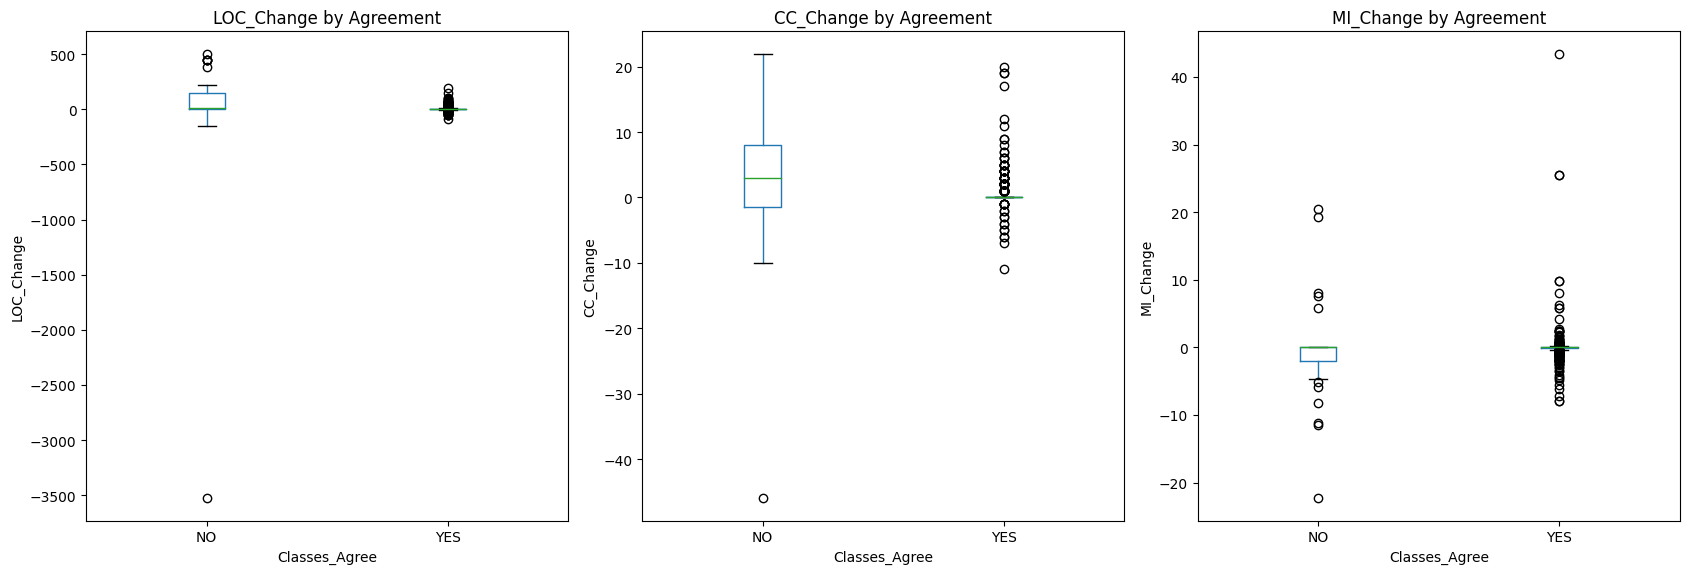

In [28]:
# Plotting these results for better understanding

import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(17,6))  # 1 row, 3 columns

# LOC_Change
dataset.dropna(subset=["LOC_Change"]).boxplot(
    column="LOC_Change", by="Classes_Agree", grid=False, ax=axes[0]
)
axes[0].set_title("LOC_Change by Agreement")
axes[0].set_xlabel("Classes_Agree")
axes[0].set_ylabel("LOC_Change")

# CC_Change
dataset.dropna(subset=["CC_Change"]).boxplot(
    column="CC_Change", by="Classes_Agree", grid=False, ax=axes[1]
)
axes[1].set_title("CC_Change by Agreement")
axes[1].set_xlabel("Classes_Agree")
axes[1].set_ylabel("CC_Change")

# MI_Change
dataset.dropna(subset=["MI_Change"]).boxplot(
    column="MI_Change", by="Classes_Agree", grid=False, ax=axes[2]
)
axes[2].set_title("MI_Change by Agreement")
axes[2].set_xlabel("Classes_Agree")
axes[2].set_ylabel("MI_Change")

plt.suptitle("")  # remove automatic title
plt.tight_layout()
plt.show()


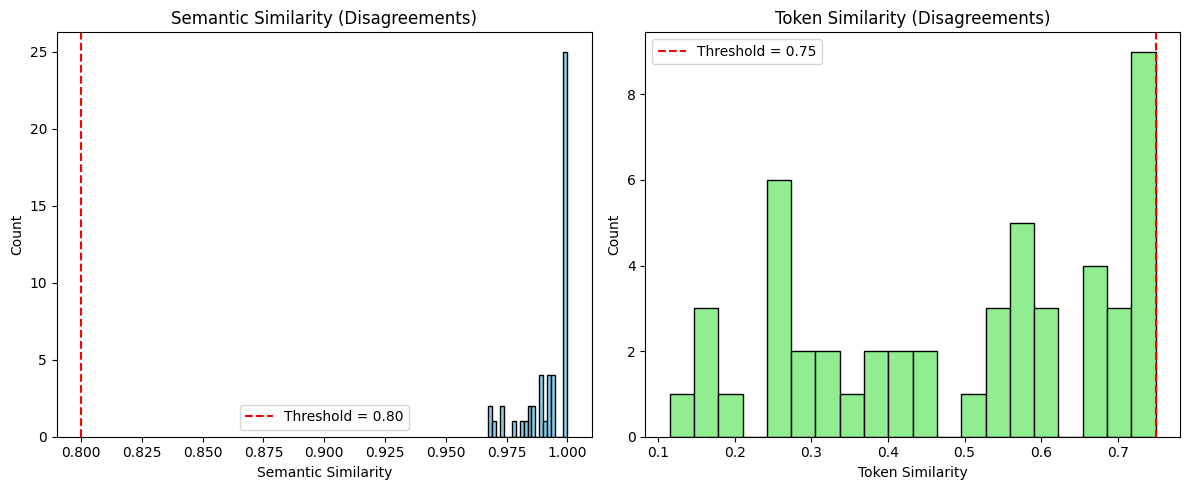

In [31]:
# Filter only disagreement cases
disagreements = dataset[dataset["Classes_Agree"] == "NO"]

plt.figure(figsize=(12,5))

# Semantic similarity distribution
plt.subplot(1,2,1)
plt.hist(disagreements["Semantic_Similarity"].dropna(), bins=20, color="skyblue", edgecolor="black")
plt.axvline(0.80, color="red", linestyle="--", label="Threshold = 0.80")
plt.title("Semantic Similarity (Disagreements)")
plt.xlabel("Semantic Similarity")
plt.ylabel("Count")
plt.legend()

# Token similarity distribution
plt.subplot(1,2,2)
plt.hist(disagreements["Token_Similarity"].dropna(), bins=20, color="lightgreen", edgecolor="black")
plt.axvline(0.75, color="red", linestyle="--", label="Threshold = 0.75")
plt.title("Token Similarity (Disagreements)")
plt.xlabel("Token Similarity")
plt.ylabel("Count")
plt.legend()

plt.tight_layout()
plt.show()